# Forecasting Models
This notebook evaluates 3 forecasting methods for each region:
- Holt-Winter’s
- SARIMA
- Prophet

Results are evaluated based on RMSE, MAE, and MAPE. The best model is selected per region.

## Holt-Winter’s Method
This method requires at least 2 full seasonal cycles of data. Regions with less data will be skipped.

## SARIMA
SARIMA accounts for seasonality, trend, and autocorrelation. Suitable for most time series.

## Prophet
Prophet is robust to missing data and handles trend/seasonality well. Confidence intervals are provided.

## Final Results
This table summarizes the best-performing model for each region based on MAPE.

## Модели прогнозирования объема убоя КРС по Акмолинской области

### Подготовка данных и EDA

Графики автокорреляционной и частичной автокорреляционной функций указывают на **сильную взаимосвязь показателей текущего месяца со значениями следующего месяца** и на возможную **годовую сезонность** (пики на +12, +24 и +36 месяцев). 

Результаты теста ADF указывают на **нестационарность** временного ряда.

In [20]:
# Создание лагов t-1 до t-6 для переменных
for lag in range(1, 7):
    df_akmola[f"КРС_t-{lag}"] = df_akmola["Объем убоя: КРС"].shift(lag)
    df_akmola[f"Температура_t-{lag}"] = df_akmola["Температура"].shift(lag)
    df_akmola[f"Осадки_t-{lag}"] = df_akmola["Осадки"].shift(lag)
    df_akmola[f"Поголовье: КРС_t-{lag}"] = df_akmola["Поголовье: КРС"].shift(lag)
    df_akmola[f"Цена: Говядина_t-{lag}"] = df_akmola["Цена: Говядина"].shift(lag)

df_akmola_full = df_akmola[["Период", "Объем убоя: КРС", 
                            "КРС_t-1", "КРС_t-2", "КРС_t-3", "КРС_t-4", "КРС_t-5", "КРС_t-6",
                            "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4", "Температура_t-5", "Температура_t-6",
                            "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4", "Осадки_t-5", "Осадки_t-6",
                            "Поголовье: КРС", "Поголовье: КРС_t-1", "Поголовье: КРС_t-2", "Поголовье: КРС_t-3", "Поголовье: КРС_t-4", "Поголовье: КРС_t-5", "Поголовье: КРС_t-6",
                            "Цена: Говядина", "Цена: Говядина_t-1", "Цена: Говядина_t-2", "Цена: Говядина_t-3", "Цена: Говядина_t-4", "Цена: Говядина_t-5", "Цена: Говядина_t-6"]]
df_akmola_full

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,КРС_t-5,КРС_t-6,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Температура_t-5,Температура_t-6,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Осадки_t-5,Осадки_t-6,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4,Поголовье: КРС_t-5,Поголовье: КРС_t-6,Цена: Говядина,Цена: Говядина_t-1,Цена: Говядина_t-2,Цена: Говядина_t-3,Цена: Говядина_t-4,Цена: Говядина_t-5,Цена: Говядина_t-6
0,2015-01-01,4455.35,NaN,NaN,NaN,NaN,NaN,NaN,-12.490323,NaN,NaN,NaN,NaN,NaN,NaN,9.8,NaN,NaN,NaN,NaN,NaN,NaN,372560.0,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-01,3654.20,4455.35,NaN,NaN,NaN,NaN,NaN,-10.192857,-12.490323,NaN,NaN,NaN,NaN,NaN,9.8,9.8,NaN,NaN,NaN,NaN,NaN,399442.0,372560.0,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN
2,2015-03-01,4287.08,3654.20,4455.35,NaN,NaN,NaN,NaN,-5.870968,-10.192857,-12.490323,NaN,NaN,NaN,NaN,8.3,9.8,9.8,NaN,NaN,NaN,NaN,425605.0,399442.0,372560.0,NaN,NaN,NaN,NaN,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN
3,2015-04-01,3923.21,4287.08,3654.20,4455.35,NaN,NaN,NaN,4.490000,-5.870968,-10.192857,-12.490323,NaN,NaN,NaN,8.8,8.3,9.8,9.8,NaN,NaN,NaN,440023.0,425605.0,399442.0,372560.0,NaN,NaN,NaN,99.800000,100.000000,100.000000,100.000000,NaN,NaN,NaN
4,2015-05-01,3849.70,3923.21,4287.08,3654.20,4455.35,NaN,NaN,14.574194,4.490000,-5.870968,-10.192857,-12.490323,NaN,NaN,42.8,8.8,8.3,9.8,9.8,NaN,NaN,444647.0,440023.0,425605.0,399442.0,372560.0,NaN,NaN,99.800000,99.800000,100.000000,100.000000,100.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-08-01,2412.70,2029.47,3951.41,3574.86,3691.05,3779.21,3446.55,17.338710,20.270968,21.043333,10.696774,8.026667,-4.809677,-13.644828,49.0,51.8,61.9,51.9,21.8,11.4,9.9,403674.0,408936.0,444063.0,441647.0,428509.0,404506.0,393245.0,251.224652,246.298678,242.898105,242.898105,236.512273,236.512273,235.569993
116,2024-09-01,2909.66,2412.70,2029.47,3951.41,3574.86,3691.05,3779.21,11.300000,17.338710,20.270968,21.043333,10.696774,8.026667,-4.809677,15.0,49.0,51.8,61.9,51.9,21.8,11.4,398450.0,403674.0,408936.0,444063.0,441647.0,428509.0,404506.0,253.485674,251.224652,246.298678,242.898105,242.898105,236.512273,236.512273
117,2024-10-01,2608.27,2909.66,2412.70,2029.47,3951.41,3574.86,3691.05,3.832258,11.300000,17.338710,20.270968,21.043333,10.696774,8.026667,15.6,15.0,49.0,51.8,61.9,51.9,21.8,392916.0,398450.0,403674.0,408936.0,444063.0,441647.0,428509.0,253.485674,253.485674,251.224652,246.298678,242.898105,242.898105,236.512273
118,2024-11-01,3649.19,2608.27,2909.66,2412.70,2029.47,3951.41,3574.86,-4.343333,3.832258,11.300000,17.338710,20.270968,21.043333,10.696774,23.7,15.6,15.0,49.0,51.8,61.9,51.9,387565.0,392916.0,398450.0,403674.0,408936.0,444063.0,441647.0,253.485674,253.485674,253.485674,251.224652,246.298678,242.898105,242.898105


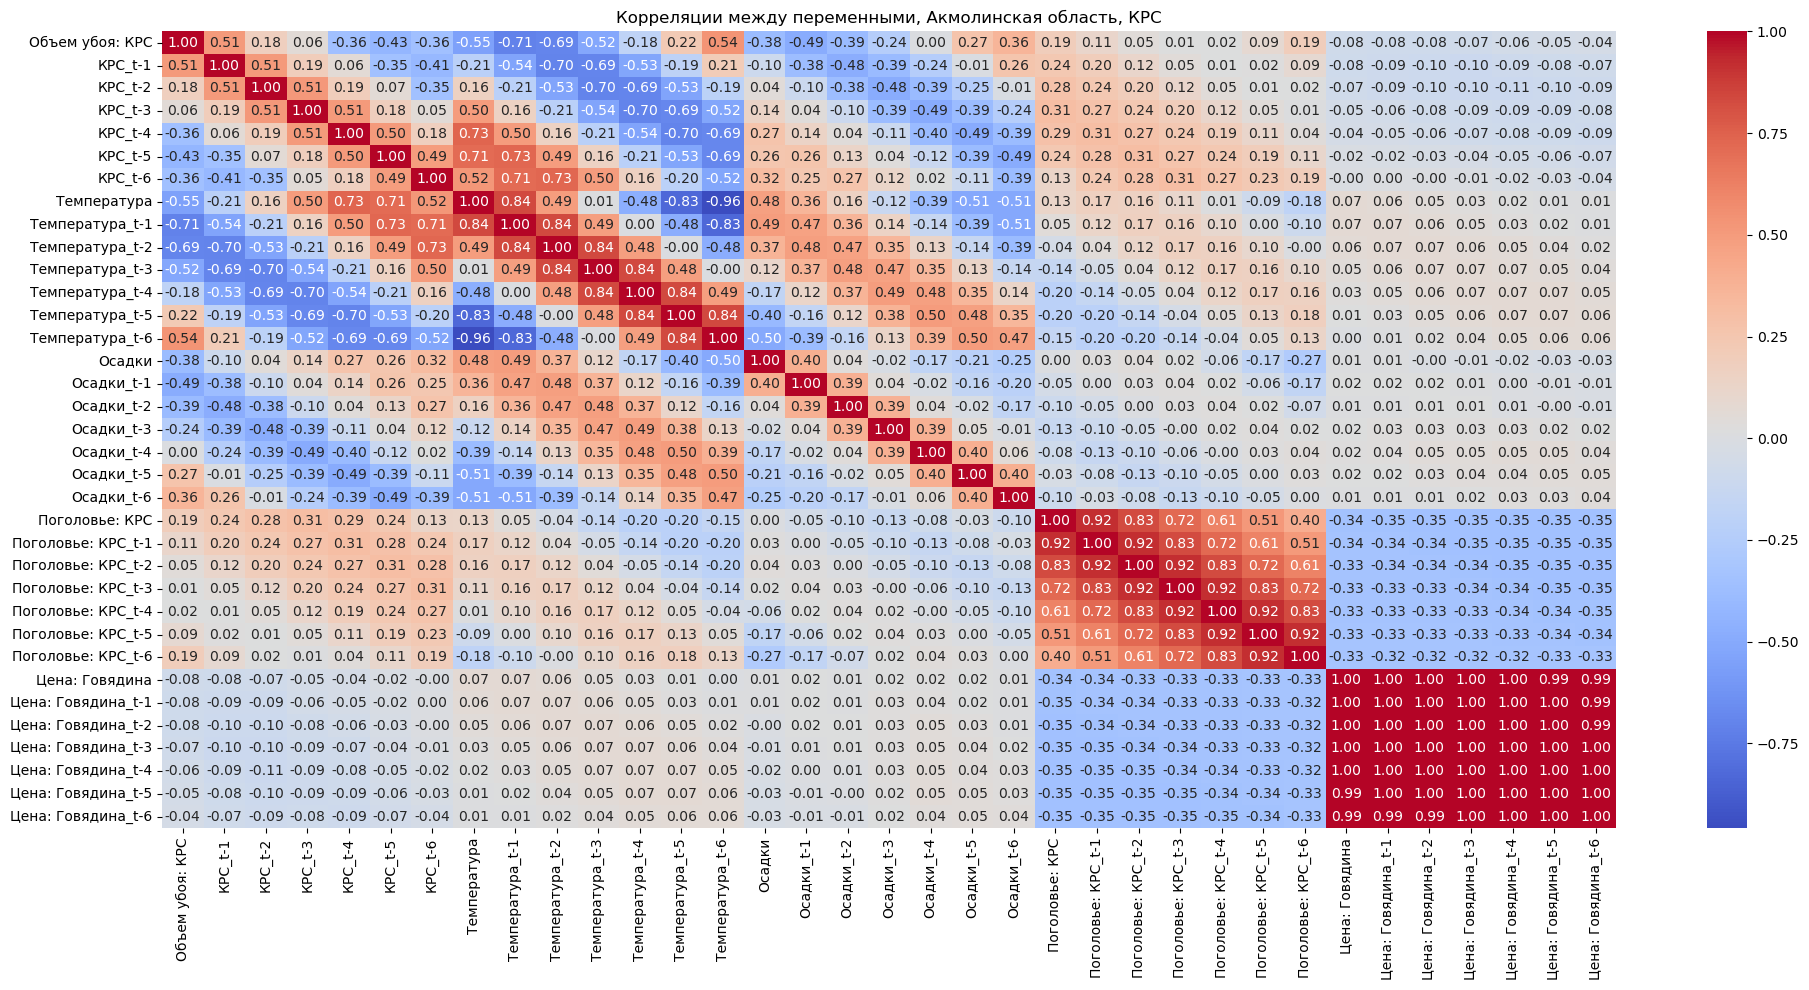

In [21]:
df_corr = df_akmola_full[[col for col in df_akmola_full.columns if col not in ["Период"]]].dropna().copy()

# 1. Correlation matrix
corr_matrix = df_corr.corr()

# 2. Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между переменными, Акмолинская область, КРС")
plt.tight_layout()
plt.show()

* Умеренная позитивная корреляция (0.51) между показателями объема убоя за все соседствующие временные периоды: между t0 и t-1, t-1 и t-2 так далее. Это свидетельствует о наличии автокорреляции в данных: значения показателя в текущем месяце частично объясняются значениями в соседних месяцах. Это типичный признак временных рядов, особенно в аграрной статистике, где производственные процессы имеют инерционный характер. Это также означает, что модели авторегрессии (AR, ARIMA, SARIMA) могут хорошо работать на этих данных, так как текущие значения "похожи" на недавние;
* Корреляция между значениями обема убоя текущего месяца и предыдущих месяцев постепенно ослабевает, в особенности после лага в t-3. Это может быть связано с тем, что основной объём данных формируется за счёт отчетности крестьянских/фермерских хозяйств и хозяйств населения, которые сдают отчетность ежеквартально. В результате, месячные значения могут быть получены путём декомпозиции квартальных показателей, что сглаживает внутриквартальные различия, но снижает связь между кварталами.
* Температура и осадки, особенно за ближайшие предыдущие месяцы, умеренно негативно коррелируют с показателями обема убоя; 
* Между показателями объема убоя и поголовья в рамках значений текущего и предыдущих месяцев корреляция слабая (0.19 и 0.12).

In [22]:
# Set your target variable
target_var = "Объем убоя: КРС"

# Get correlations with the target variable
target_corr = corr_matrix[target_var].drop(target_var)  # exclude self-correlation

# Keep only features with |correlation| >= 0.5
selected_vars = target_corr[abs(target_corr) >= 0.5].index.tolist()

print("✅ Отобранные переменные с корреляцией >= 0.5:")
print(selected_vars)

# Optionally: create new dataframe with selected variables + target
df_selected = df_akmola_full[['Период'] + selected_vars + [target_var]]
df_selected

✅ Отобранные переменные с корреляцией >= 0.5:
['КРС_t-1', 'Температура', 'Температура_t-1', 'Температура_t-2', 'Температура_t-3', 'Температура_t-6']


,Период,КРС_t-1,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-6,Объем убоя: КРС
0,2015-01-01,NaN,-12.490323,NaN,NaN,NaN,NaN,4455.35
1,2015-02-01,4455.35,-10.192857,-12.490323,NaN,NaN,NaN,3654.20
2,2015-03-01,3654.20,-5.870968,-10.192857,-12.490323,NaN,NaN,4287.08
3,2015-04-01,4287.08,4.490000,-5.870968,-10.192857,-12.490323,NaN,3923.21
4,2015-05-01,3923.21,14.574194,4.490000,-5.870968,-10.192857,NaN,3849.70
...,...,...,...,...,...,...,...,...
115,2024-08-01,2029.47,17.338710,20.270968,21.043333,10.696774,-13.644828,2412.70
116,2024-09-01,2412.70,11.300000,17.338710,20.270968,21.043333,-4.809677,2909.66
117,2024-10-01,2909.66,3.832258,11.300000,17.338710,20.270968,8.026667,2608.27
118,2024-11-01,2608.27,-4.343333,3.832258,11.300000,17.338710,10.696774,3649.19


In [23]:
df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период"]]].dropna().copy()

X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Объем убоя: КРС"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data.sort_values('VIF')

,Variable,VIF
1,КРС_t-1,2.143338
5,Температура_t-3,13.618455
6,Температура_t-6,14.624599
2,Температура,17.070220
4,Температура_t-2,18.906931
3,Температура_t-1,21.718738
0,const,44.278197


Step-by-Step Strategy to Handle High VIFs:

Sort VIFs in descending order
Drop variables one at a time, starting with the one that has the highest VIF.

Check domain relevance
Keep variables that are theoretically important or core to your hypothesis, even if VIF is high.

Evaluate correlation matrix
If two variables have high correlation with each other, and both have high VIFs, drop the one less correlated with the target.

Recalculate VIF after each drop
After dropping one variable, recalculate all VIFs. Sometimes removing just one variable significantly reduces others.

Use stepwise selection (optional)
Automated methods like backward elimination can help drop redundant predictors based on model fit and VIF thresholds.

In [24]:
df_selected = df_selected.drop(columns = ['Температура', 'Температура_t-2', 'Температура_t-3', 'Температура_t-6'])
df_selected

,Период,КРС_t-1,Температура_t-1,Объем убоя: КРС
0,2015-01-01,NaN,NaN,4455.35
1,2015-02-01,4455.35,-12.490323,3654.20
2,2015-03-01,3654.20,-10.192857,4287.08
3,2015-04-01,4287.08,-5.870968,3923.21
4,2015-05-01,3923.21,4.490000,3849.70
...,...,...,...,...
115,2024-08-01,2029.47,20.270968,2412.70
116,2024-09-01,2412.70,17.338710,2909.66
117,2024-10-01,2909.66,11.300000,2608.27
118,2024-11-01,2608.27,3.832258,3649.19


In [25]:
df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период"]]].dropna().copy()
X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Объем убоя: КРС"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data.sort_values('VIF')

,Variable,VIF
1,КРС_t-1,1.403348
2,Температура_t-1,1.403348
0,const,25.526361


In [26]:
df_selected = df_selected.dropna().copy()
df_selected

,Период,КРС_t-1,Температура_t-1,Объем убоя: КРС
1,2015-02-01,4455.35,-12.490323,3654.20
2,2015-03-01,3654.20,-10.192857,4287.08
3,2015-04-01,4287.08,-5.870968,3923.21
4,2015-05-01,3923.21,4.490000,3849.70
5,2015-06-01,3849.70,14.574194,4074.13
...,...,...,...,...
115,2024-08-01,2029.47,20.270968,2412.70
116,2024-09-01,2412.70,17.338710,2909.66
117,2024-10-01,2909.66,11.300000,2608.27
118,2024-11-01,2608.27,3.832258,3649.19


### Models

#### Многофакторная регрессия

In [27]:
# Define target and features
y = df_selected["Объем убоя: КРС"]
X = df_selected.drop(columns=["Период", "Объем убоя: КРС"])

# Add constant term
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Объем убоя: КРС   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     60.68
Date:                Wed, 28 May 2025   Prob (F-statistic):           9.24e-19
Time:                        16:49:25   Log-Likelihood:                -936.12
No. Observations:                 119   AIC:                             1878.
Df Residuals:                     116   BIC:                             1887.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3121.6330    296.095     

In [28]:
df_selected

,Период,КРС_t-1,Температура_t-1,Объем убоя: КРС
1,2015-02-01,4455.35,-12.490323,3654.20
2,2015-03-01,3654.20,-10.192857,4287.08
3,2015-04-01,4287.08,-5.870968,3923.21
4,2015-05-01,3923.21,4.490000,3849.70
5,2015-06-01,3849.70,14.574194,4074.13
...,...,...,...,...
115,2024-08-01,2029.47,20.270968,2412.70
116,2024-09-01,2412.70,17.338710,2909.66
117,2024-10-01,2909.66,11.300000,2608.27
118,2024-11-01,2608.27,3.832258,3649.19


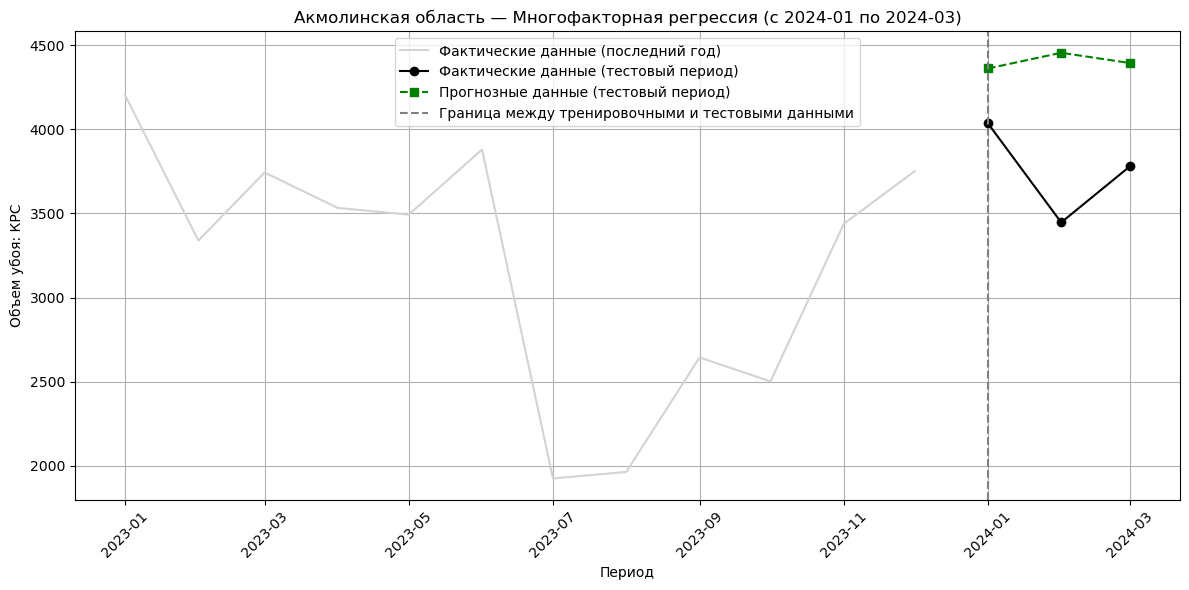

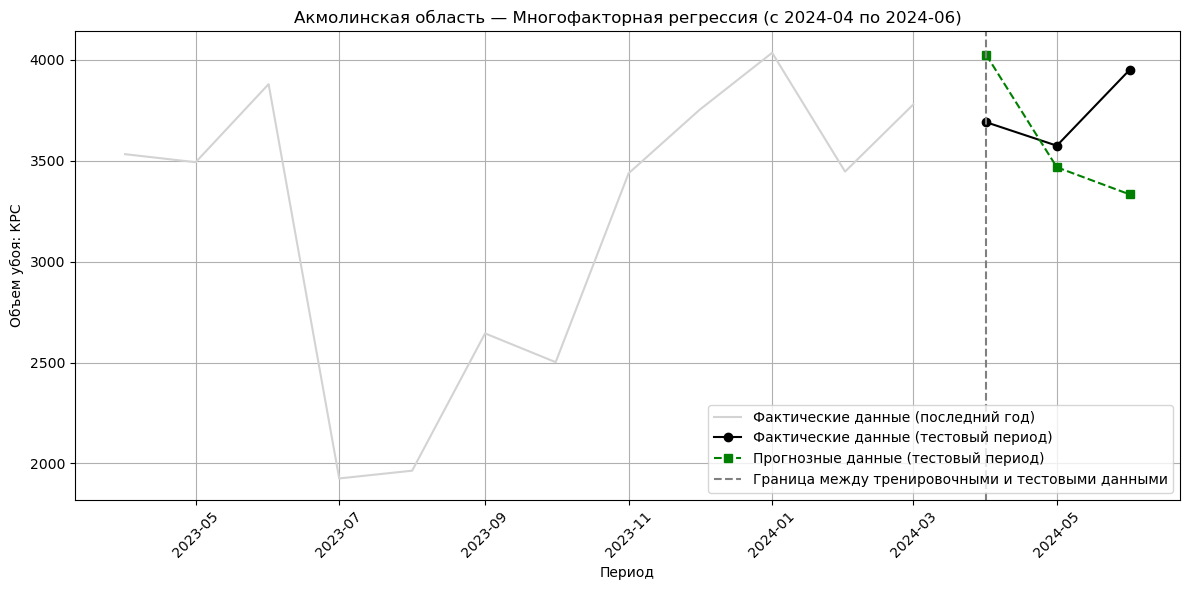

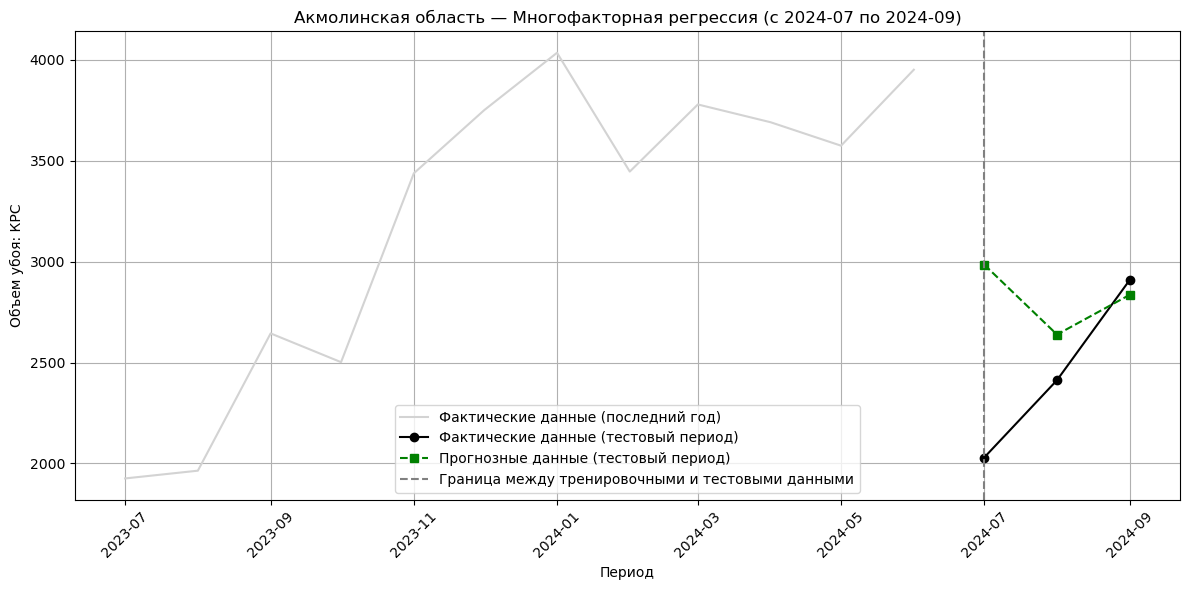

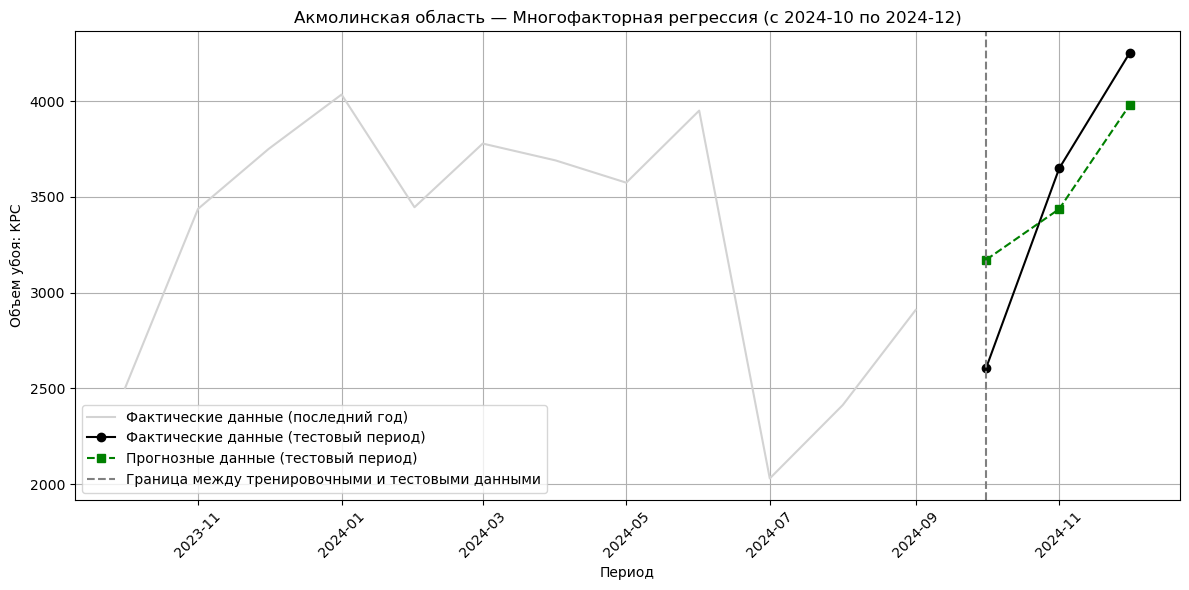

In [29]:
df = df_selected.sort_values("Период").copy()

target = "Объем убоя: КРС"
features = [col for col in df_selected.columns if col not in ['Период', 'Объем убоя: КРС']]

results = []

# Define 4 rolling test sets for 2024
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    X_train = sm.add_constant(train_df[features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        # "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Многофакторная регрессия (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [30]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period        RMSE         MAE   MAPE (%)
0  2024-01 to 2024-03  707.056575  649.419356  17.859737
1  2024-04 to 2024-06  410.230560  352.890504   9.224227
2  2024-07 to 2024-09  568.628892  418.536520  19.666694
3  2024-10 to 2024-12  381.772797  349.424766  11.278686
4             Average  516.922206  442.567786  14.507336


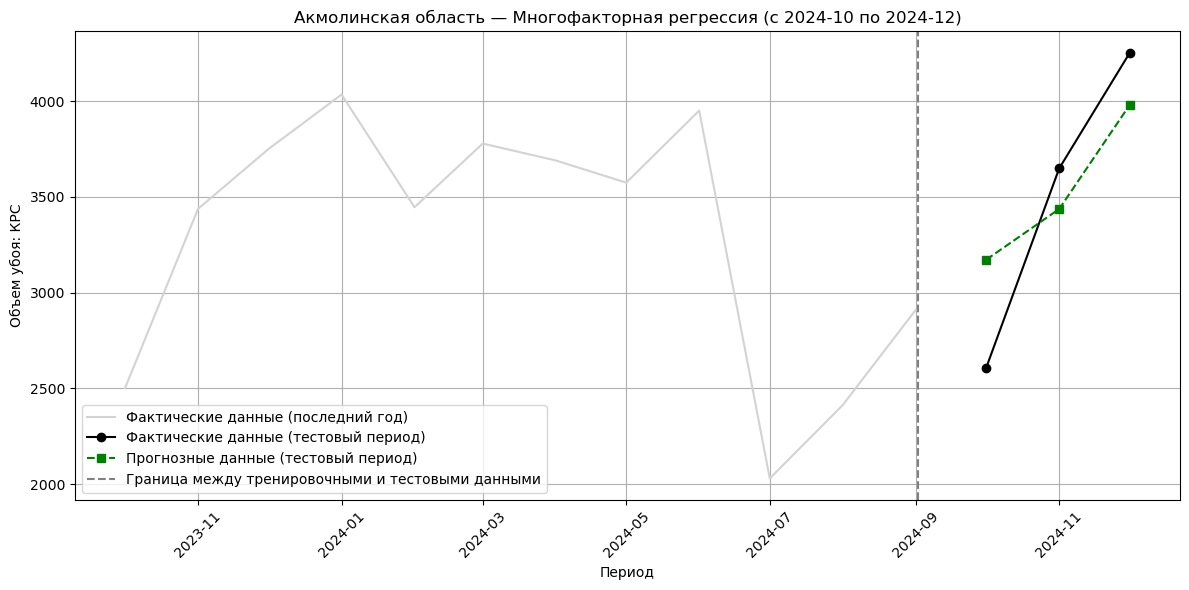

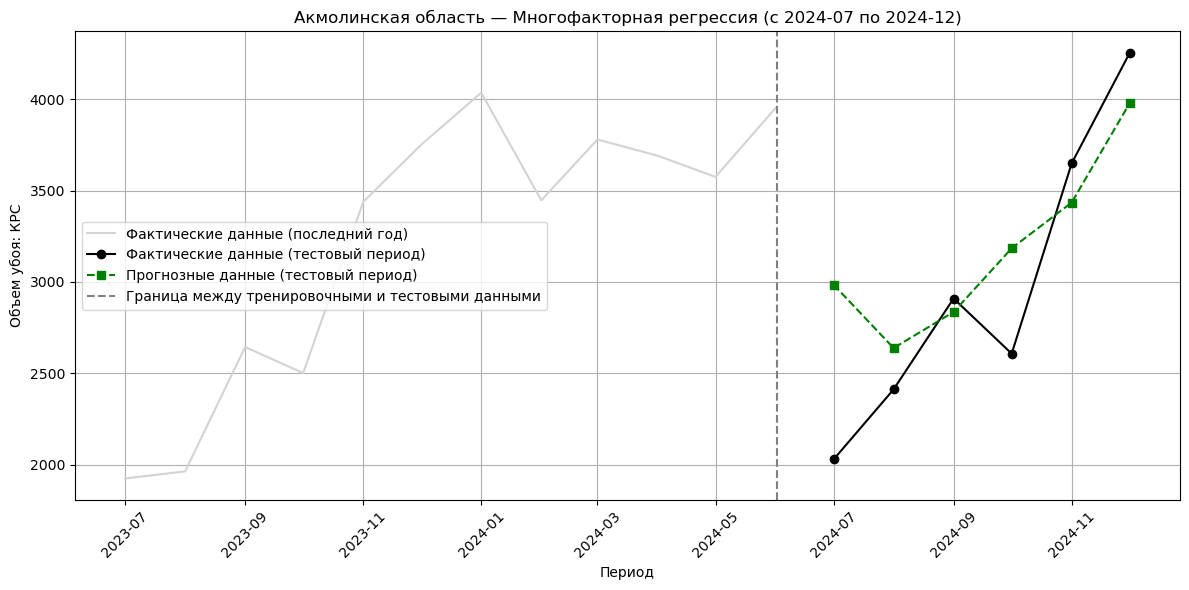

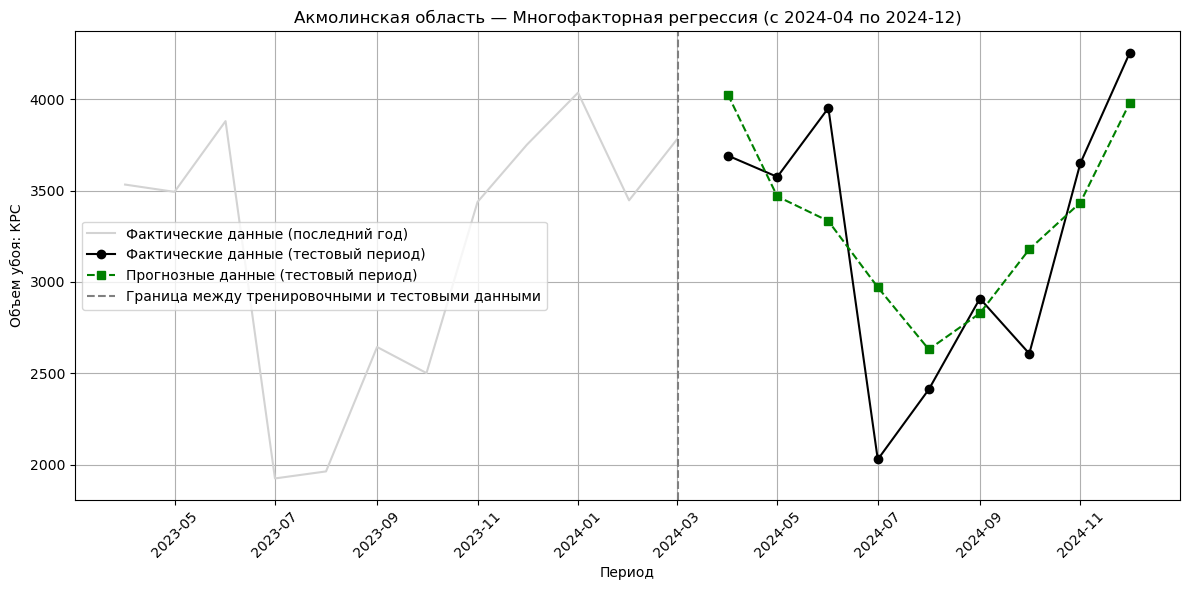

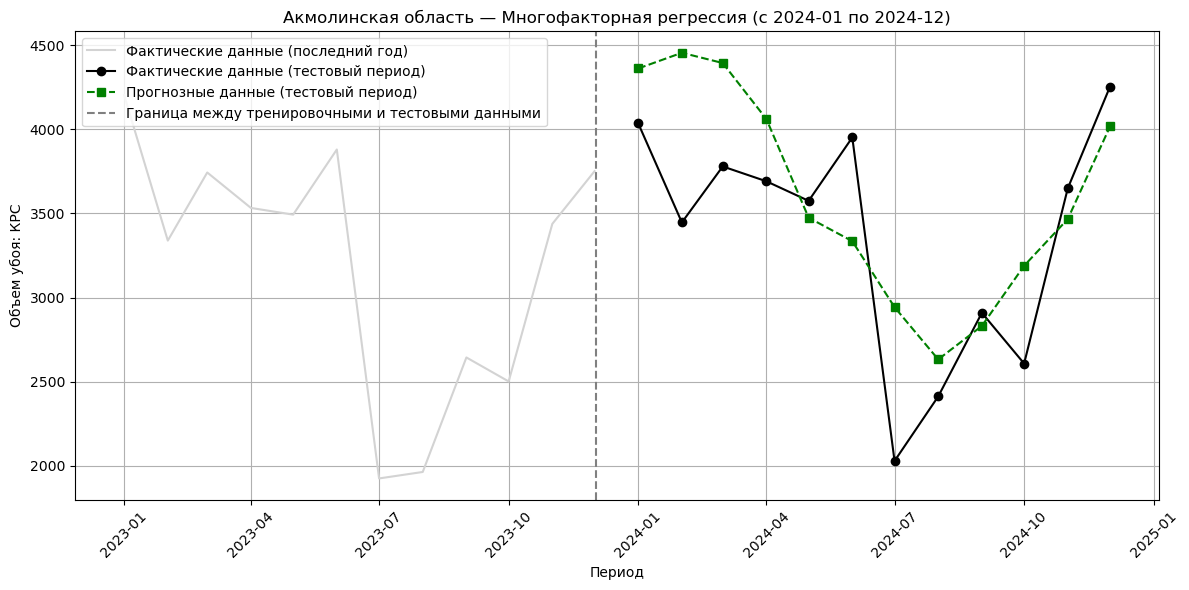

In [31]:
results = []

# Define 4 rolling test sets for 2024
horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    X_train = sm.add_constant(train_df[features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        # "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Многофакторная регрессия (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [32]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period        RMSE         MAE   MAPE (%)
0  2024-10 to 2024-12  381.772797  349.424766  11.278686
1  2024-07 to 2024-12  487.048987  386.806124  15.570101
2  2024-04 to 2024-12  458.606082  373.227105  13.346326
3  2024-01 to 2024-12  527.749724  437.163192  14.303707
4             Average  463.794397  386.655297  13.624705


#### SARIMA (auto-arima)

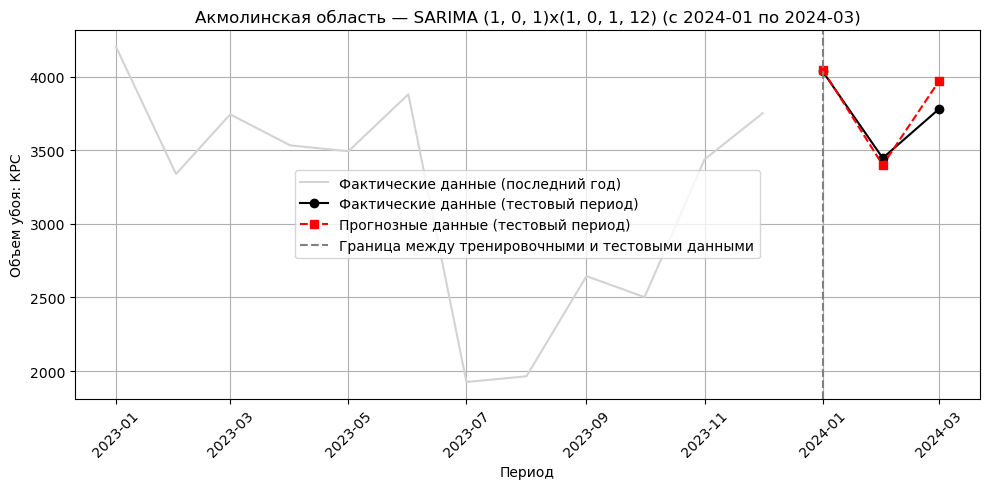

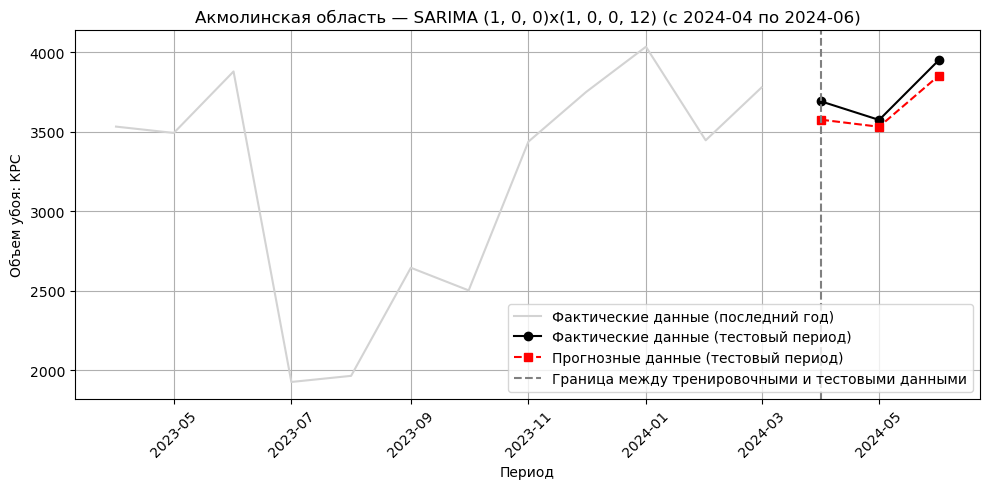

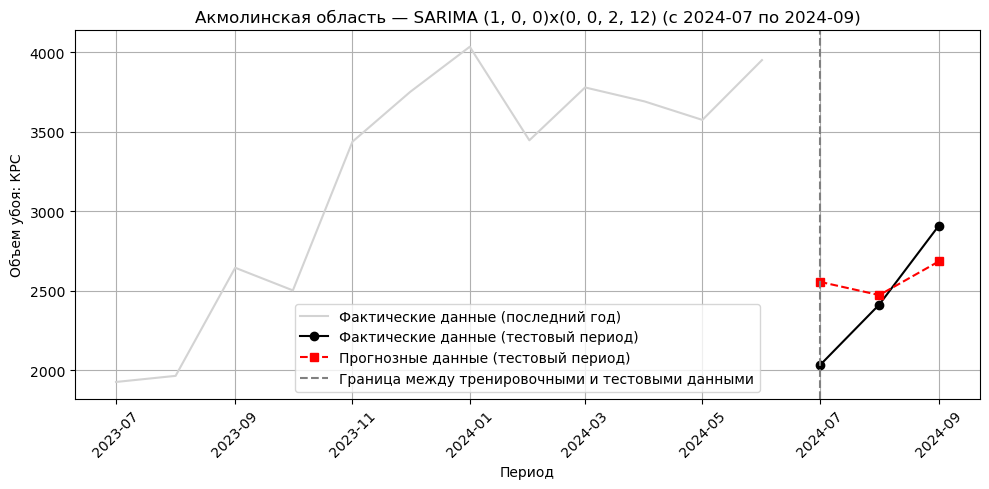

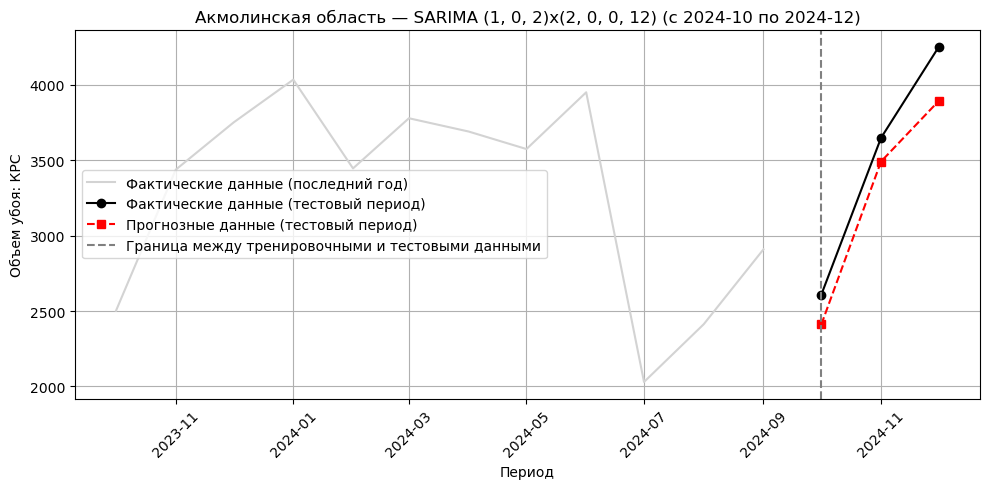

In [33]:
results = []

# Определим 4 тестовых периода на 3 месяца
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=3)
        forecast = pd.Series(forecast).reset_index(drop=True)


        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMA {model.order}x{model.seasonal_order} (с {test_start.strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [34]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period        RMSE         MAE   MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  112.573699   82.636517   2.220632    (1, 0, 1)   
1  2024-04 to 2024-06   90.476733   85.152078   2.261681    (1, 0, 0)   
2  2024-07 to 2024-09  332.542404  270.586710  12.057791    (1, 0, 0)   
3  2024-10 to 2024-12  253.221203  237.753450   6.769396    (1, 0, 2)   
4             Average  197.203509  169.032189   5.827375          NaN   

  Seasonal order  
0  (1, 0, 1, 12)  
1  (1, 0, 0, 12)  
2  (0, 0, 2, 12)  
3  (2, 0, 0, 12)  
4            NaN  


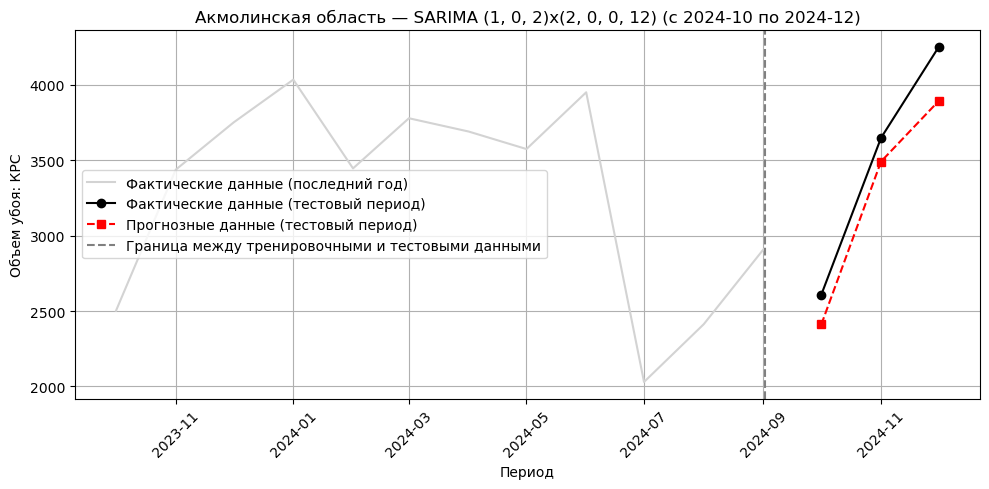

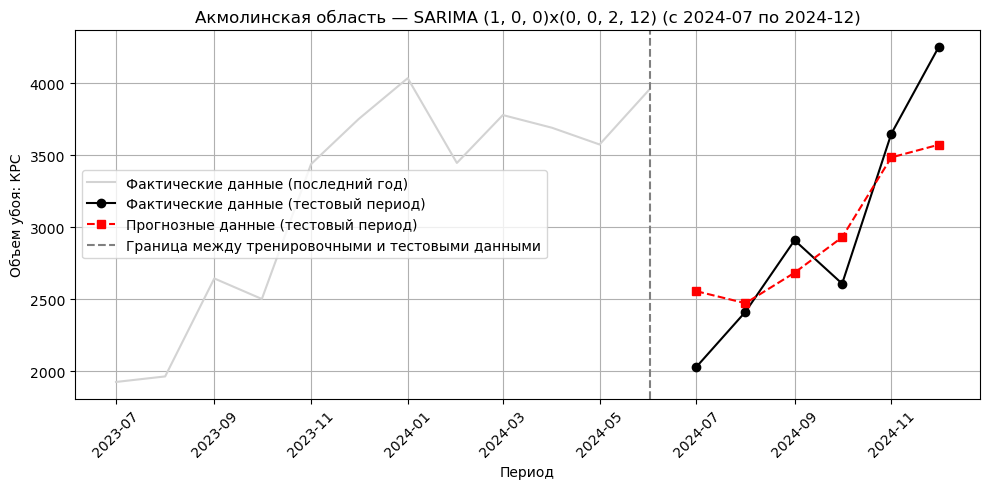

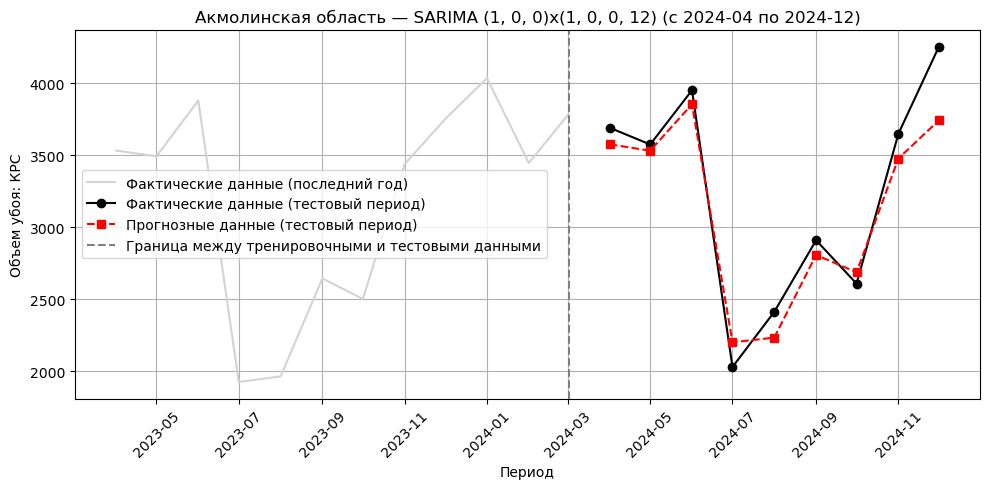

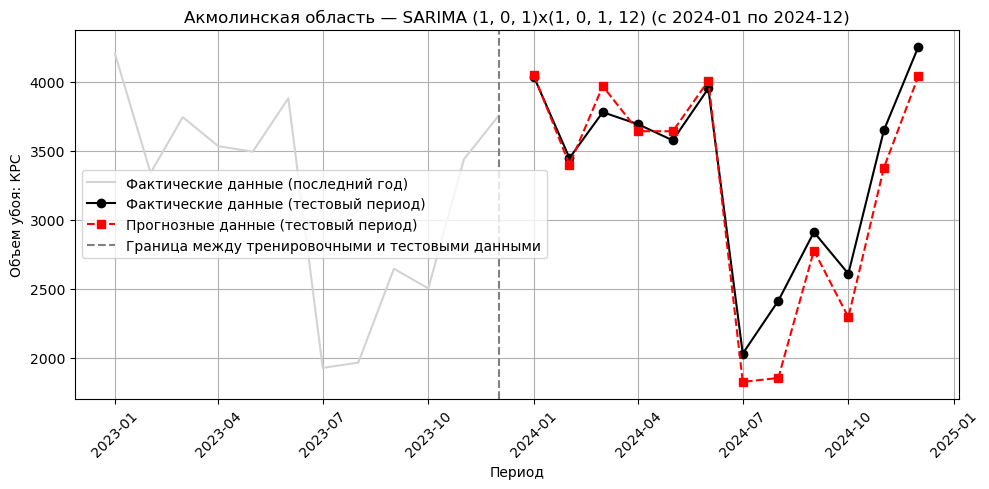

In [35]:
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)
    
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=horizon)
        forecast = pd.Series(forecast).reset_index(drop=True)

        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMA {model.order}x{model.seasonal_order} (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [36]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period        RMSE         MAE   MAPE (%) SARIMA order  \
0  2024-10 to 2024-12  253.221203  237.753450   6.769396    (1, 0, 2)   
1  2024-07 to 2024-12  392.701920  329.738723  11.503269    (1, 0, 0)   
2  2024-04 to 2024-12  209.285679  163.466097   5.107425    (1, 0, 0)   
3  2024-01 to 2024-12  230.971020  176.545797   6.143900    (1, 0, 1)   
4             Average  271.544955  226.876017   7.380997          NaN   

  Seasonal order  
0  (2, 0, 0, 12)  
1  (0, 0, 2, 12)  
2  (1, 0, 0, 12)  
3  (1, 0, 1, 12)  
4            NaN  


#### SARIMAX

c:\Users\mjaks\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


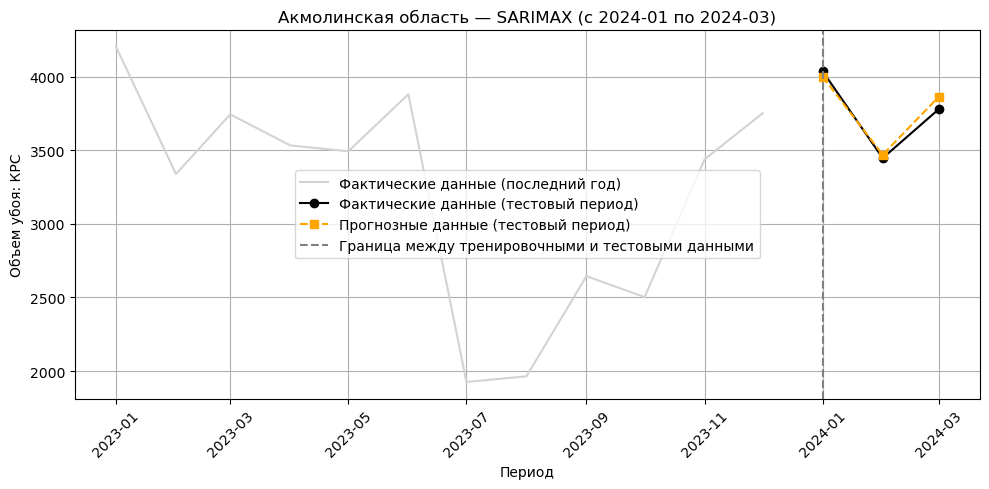

c:\Users\mjaks\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


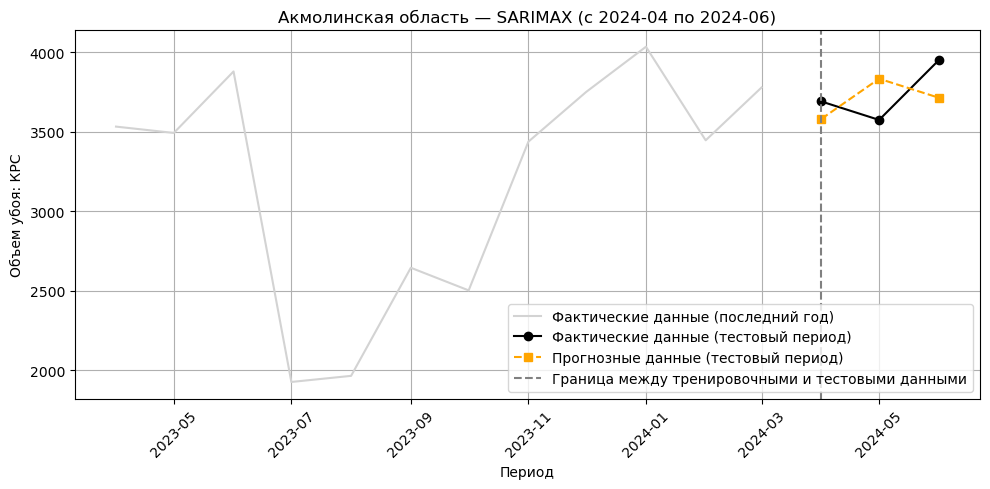

c:\Users\mjaks\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


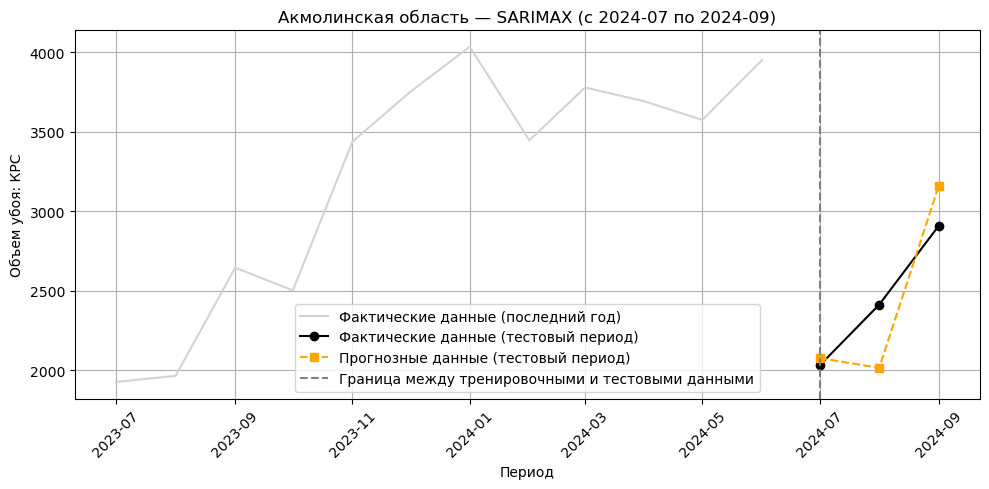

c:\Users\mjaks\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


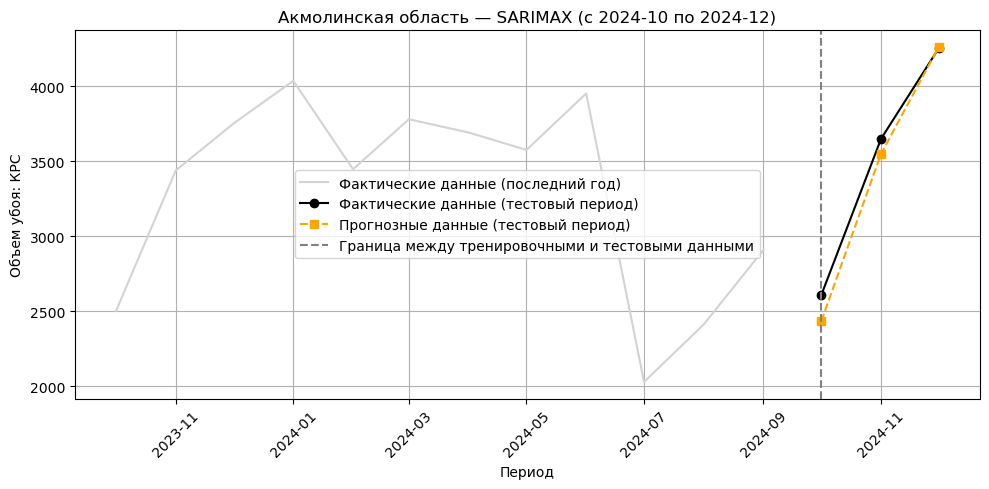

In [37]:
results = []

start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[features].reset_index(drop=True)
    exog_test = test_df[features].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(1, 0, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=3, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMAX (с {start} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [38]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)



          Test period        RMSE         MAE  MAPE (%) SARIMA order  \
0  2024-01 to 2024-03   54.574853   47.718068  1.261404            1   
1  2024-04 to 2024-06  212.560923  202.141967  5.411596            1   
2  2024-07 to 2024-09  273.647731  232.481954  9.161773            1   
3  2024-10 to 2024-12  116.227832   94.454330  3.212427            1   
4             Average  164.252835  144.199080  4.761800                

  Seasonal order  
0             12  
1             12  
2             12  
3             12  
4                 


c:\Users\mjaks\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


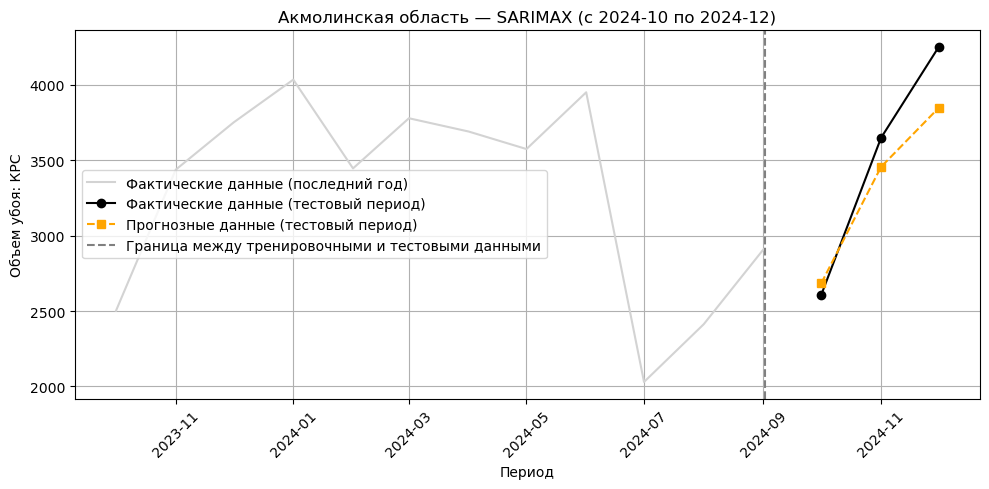

c:\Users\mjaks\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


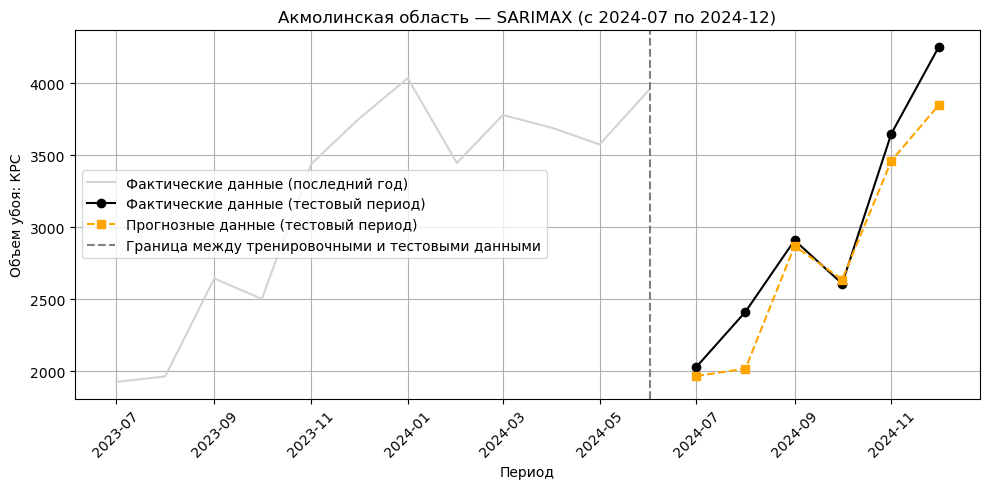

c:\Users\mjaks\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


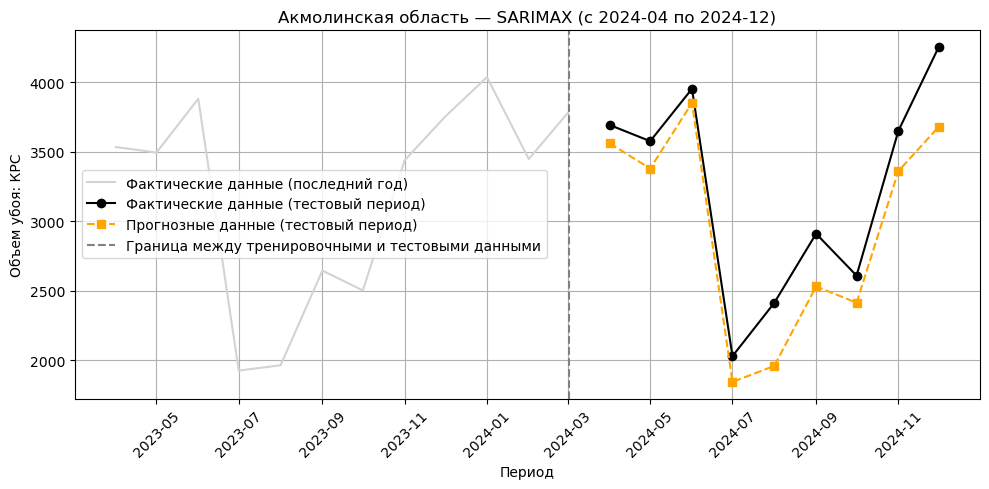

c:\Users\mjaks\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


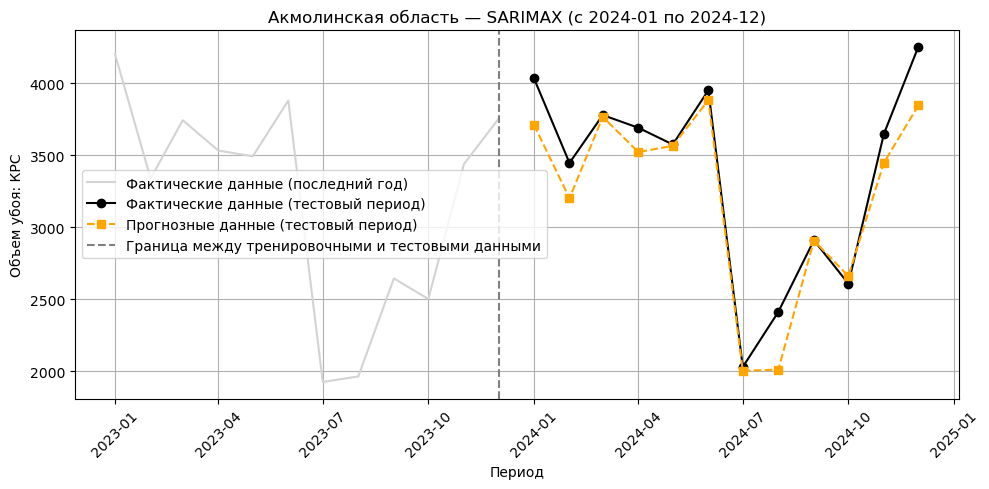

In [39]:
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[features].reset_index(drop=True)
    exog_test = test_df[features].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(1, 0, 0),
            seasonal_order=(1, 0, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=horizon, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMAX (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [40]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)

          Test period        RMSE         MAE  MAPE (%) SARIMA order  \
0  2024-10 to 2024-12  262.423051  224.549688  5.906647            1   
1  2024-07 to 2024-12  245.258646  186.208110  6.090010            1   
2  2024-04 to 2024-12  316.463445  278.509310  9.055744            1   
3  2024-01 to 2024-12  217.699026  159.845083  4.759848            1   
4             Average  260.461042  212.278048  6.453062                

  Seasonal order  
0             12  
1             12  
2             12  
3             12  
4                 


#### Prophet

16:53:23 - cmdstanpy - INFO - Chain [1] start processing
16:53:23 - cmdstanpy - INFO - Chain [1] done processing


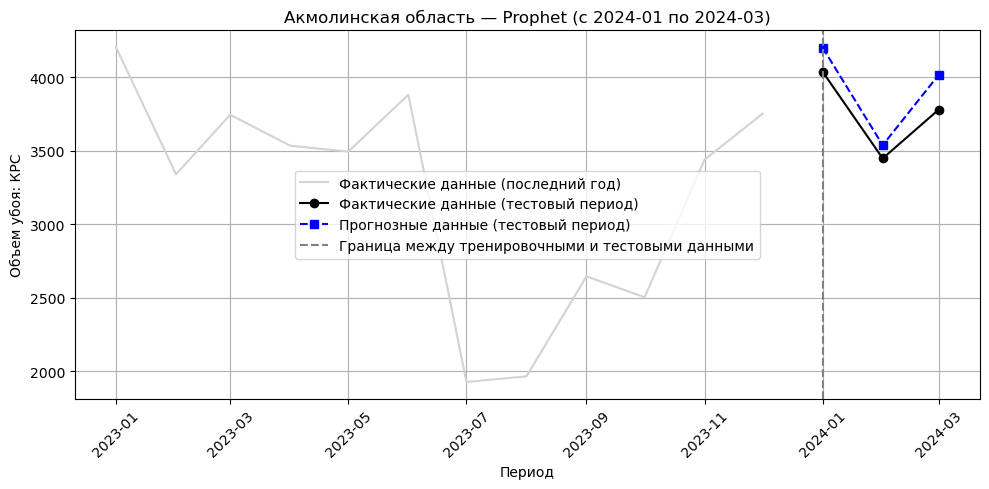

16:53:23 - cmdstanpy - INFO - Chain [1] start processing
16:53:24 - cmdstanpy - INFO - Chain [1] done processing


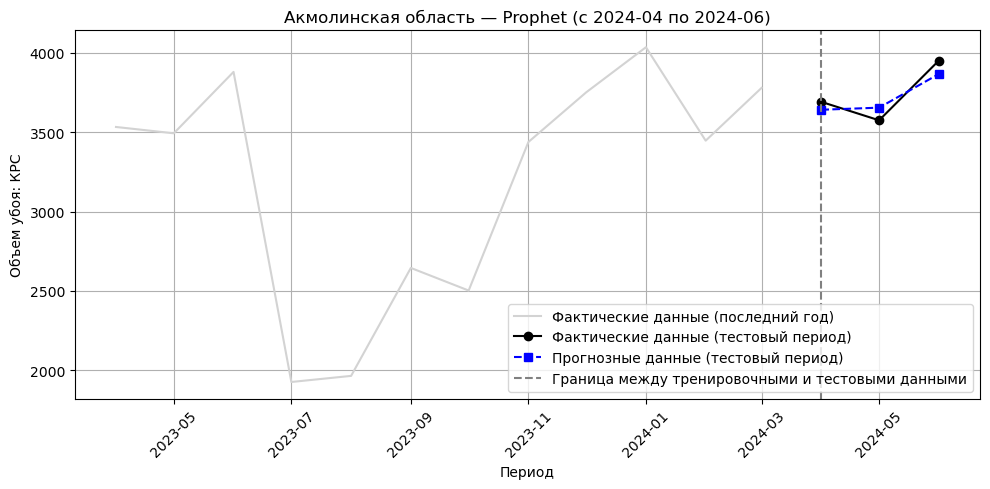

16:53:24 - cmdstanpy - INFO - Chain [1] start processing
16:53:24 - cmdstanpy - INFO - Chain [1] done processing


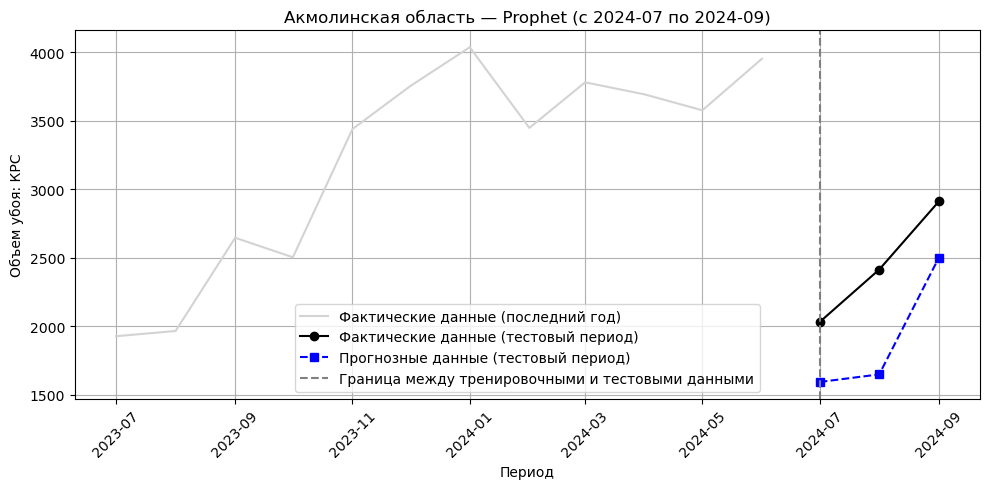

16:53:25 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] done processing


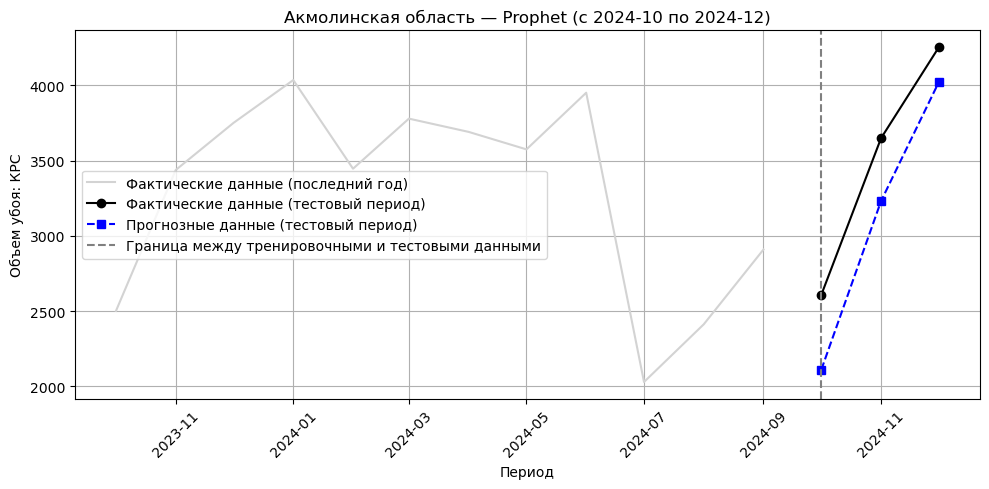

In [41]:
results = []

# Define 4 test periods
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Train/test split
    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Initialize Prophet
    model = Prophet()

    # Optional: add regressors
    # model.add_regressor("Температура_t-1")
    # prophet_train["Температура_t-1"] = train_df["Температура_t-1"].values
    # prophet_test["Температура_t-1"] = test_df["Температура_t-1"].values

    # Fit
    model.fit(prophet_train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=3, freq="M")
    forecast = model.predict(future)
# forecast
# prophet_test

    # Extract forecast for test period only
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Prophet (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [42]:
results_df = pd.DataFrame(results)
avg = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg])], ignore_index=True)
print(results_df)

          Test period        RMSE         MAE   MAPE (%)
0  2024-01 to 2024-03  174.376646  163.697319   4.316370
1  2024-04 to 2024-06   73.022584   71.366810   1.906491
2  2024-07 to 2024-09  561.526946  537.861728  22.466480
3  2024-10 to 2024-12  398.146060  382.183370  11.986217
4             Average  301.768059  288.777307  10.168890


16:53:26 - cmdstanpy - INFO - Chain [1] start processing
16:53:26 - cmdstanpy - INFO - Chain [1] done processing


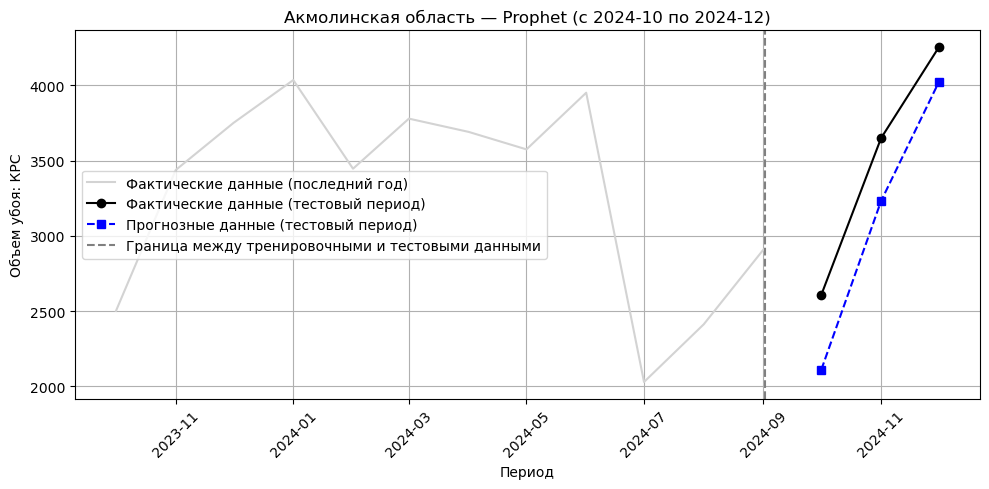

16:53:27 - cmdstanpy - INFO - Chain [1] start processing
16:53:27 - cmdstanpy - INFO - Chain [1] done processing


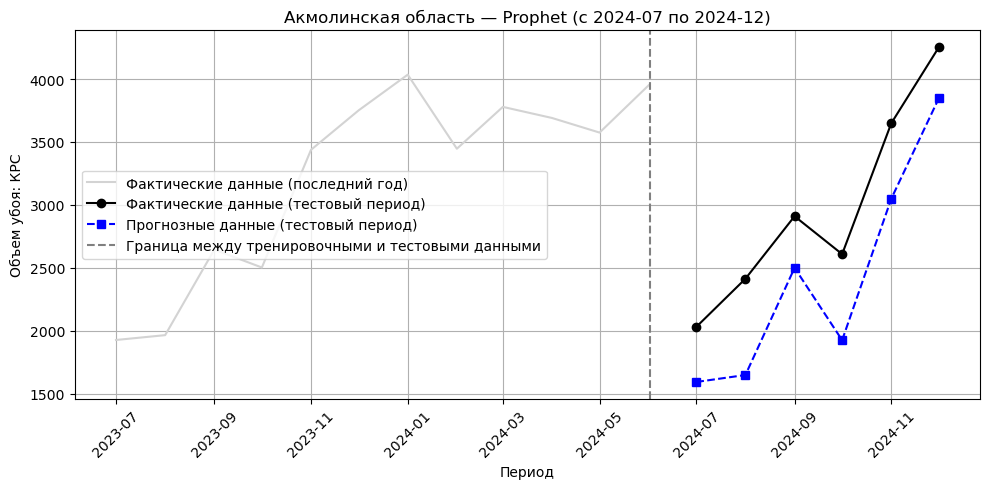

16:53:28 - cmdstanpy - INFO - Chain [1] start processing
16:53:28 - cmdstanpy - INFO - Chain [1] done processing


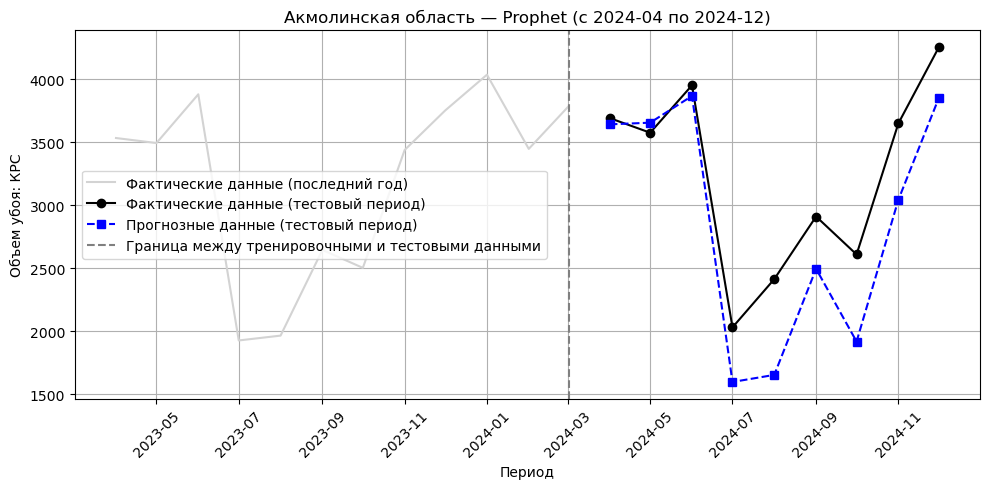

16:53:28 - cmdstanpy - INFO - Chain [1] start processing
16:53:28 - cmdstanpy - INFO - Chain [1] done processing


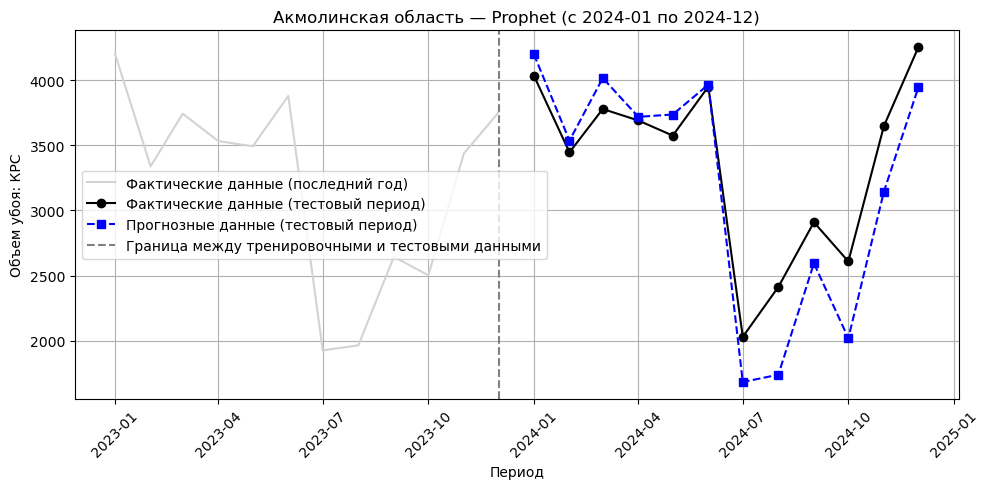

In [43]:
horizons = [3, 6, 9, 12]
results = []

for horizon in horizons:

    # Define train/test split
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Fit Prophet
    model = Prophet()
    model.fit(prophet_train)

    # Forecast
    future = model.make_future_dataframe(periods=horizon, freq="M")
    forecast = model.predict(future)

    # Extract matching forecasted months
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Prophet (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [44]:
# Summary table
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)

          Test period        RMSE         MAE   MAPE (%)
0  2024-10 to 2024-12  398.146060  382.183370  11.986217
1  2024-07 to 2024-12  568.419628  550.552544  19.934839
2  2024-04 to 2024-12  466.881066  391.444715  13.937699
3  2024-01 to 2024-12  352.168766  286.125236   9.842988
4                 NaN  446.403880  402.576466  13.925436


strength of correlation:
https://link.springer.com/article/10.1057/jt.2009.5#
https://resources.nu.edu/statsresources/correlation